In [7]:
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import matplotlib.pyplot as plt
from collections import Counter

In [9]:
# === 1) Load Data ===
# Use your absolute path. Later, switch to Path("../data") for portability.
DATA_DIR = Path(r"C:\Users\tsabu\Resume Projects\career-skill-recommender\data")

postings_path = DATA_DIR / "job_postings.csv"
postings = pd.read_csv(
    postings_path,
    lineterminator="\n",     # handle unusual line terminators
    encoding="utf-8",
    on_bad_lines="skip"      # ignore problematic rows
)

print("Loaded postings:", postings.shape)
print("Columns:", postings.columns.tolist())

# === 2) Load skills vocabulary from file ===
skills_file = DATA_DIR / "skills" / "skills_list.txt"

with open(skills_file, "r", encoding="utf-8") as f:
    SKILL_VOCAB = [
        line.strip().lower()
        for line in f
        if line.strip() and not line.startswith("#")
    ]

# sort by length (desc) so multi-word skills match before single words
SKILL_VOCAB = sorted(set(SKILL_VOCAB), key=len, reverse=True)
print(f"Loaded {len(SKILL_VOCAB)} skills from {skills_file}")

# === 3) Regex skill matcher ===
def compile_pattern(skill):
    pattern = r"\b" + re.sub(r"\s+", r"\\s+", re.escape(skill)) + r"\b"
    return re.compile(pattern, flags=re.IGNORECASE)

SKILL_PATTERNS = {s: compile_pattern(s) for s in SKILL_VOCAB}

def extract_skills(text):
    if pd.isna(text): 
        return set()
    t = str(text).lower()
    return {s for s, pat in SKILL_PATTERNS.items() if pat.search(t)}

# Combine skills_desc + description text, then extract skills
postings["_combined_text"] = (
    postings[["skills_desc", "description"]]
    .fillna("")
    .agg(" ".join, axis=1)
)
postings["_skills_extracted"] = postings["_combined_text"].apply(extract_skills)

# === 4) Role -> skill set mapping ===
role_to_skills = (
    postings.groupby("title")["_skills_extracted"]
    .apply(lambda sets: set().union(*sets))
    .to_dict()
)

print("Roles with >=1 extracted skill:",
      sum(1 for v in role_to_skills.values() if v),
      "of", len(role_to_skills))

# Create documents for TF-IDF
role_docs = {role: " ".join(sorted(skills)) for role, skills in role_to_skills.items()}
roles_list = list(role_docs.keys())
docs_list = [role_docs[r] for r in roles_list]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(docs_list)

# === 5) Recommend functions ===
def recommend_roles(user_skills, top_n=5):
    user = [s.lower().strip() for s in user_skills]
    query = " ".join([s for s in user if s in SKILL_VOCAB])
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, X).flatten()
    order = sims.argsort()[::-1][:top_n]
    return [(roles_list[i], round(float(sims[i]), 3)) for i in order]

def recommend_missing_skills_partial(role_keyword, user_skills, top_n_roles=5):
    user_set = {s.lower().strip() for s in user_skills}
    matches = [r for r in roles_list if role_keyword.lower() in r.lower()]
    if not matches:
        return {}
    out = {}
    for r in matches[:top_n_roles]:
        missing = sorted(role_to_skills.get(r, set()) - user_set)
        out[r] = missing
    return out

# === 6) Demo ===
user = ["python", "sql", "pandas"]

print("\n--- Recommended Roles ---")
print(recommend_roles(user, top_n=5))

print("\n--- Missing Skills (Data Scientist variants) ---")
ms = recommend_missing_skills_partial("data scientist", user, top_n_roles=5)
for role, missing in ms.items():
    print("-", role, ":", missing[:15])  # show first 15 skills

Loaded postings: (123849, 31)
Columns: ['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips']
Loaded 292 skills from C:\Users\tsabu\Resume Projects\career-skill-recommender\data\skills\skills_list.txt
Roles with >=1 extracted skill: 31818 of 72521

--- Recommended Roles ---
[('Remote opportunity for P&C Insurance Data Scientist/Actuary - PR12690A', 1.0), ('Cybersecurity Data Engineer', 0.859), ('Medicaid Business Intelligence Engineer', 0.838), ('GoLang Developer (Capital One Experience Required) - ***W2 Only***', 0.777), ('Data Scientist - Equity Trading', 0.751)]

---

In [11]:
# === 7) Filtered Role Recommendation Function ===
# This function allows you to filter recommendations by a keyword in the job title.
def recommend_roles_filtered(user_skills, title_filter="", top_n=5):
    user = [s.lower().strip() for s in user_skills]
    query = " ".join([s for s in user if s in SKILL_VOCAB])
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, X).flatten()

    # Apply title filter if provided
    if title_filter:
        mask = [title_filter.lower() in r.lower() for r in roles_list]
        scored = [(i, float(sims[i])) for i, keep in enumerate(mask) if keep]
    else:
        scored = [(i, float(sims[i])) for i, _ in enumerate(roles_list)]

    scored.sort(key=lambda x: x[1], reverse=True)
    picked = scored[:top_n]
    return [(roles_list[i], round(score, 3)) for i, score in picked]

# Demo the filtered recommendation
user_skills_for_demo = ["python", "sql", "pandas"]
print("\n--- Recommended Roles (filtered: Data Scientist) ---")
print(recommend_roles_filtered(user_skills_for_demo, title_filter="data engineer"))


--- Recommended Roles (filtered: Data Scientist) ---
[('Cybersecurity Data Engineer', 0.859), ('Geospatial Data Engineer II', 0.664), ('Data Engineer (Internship)', 0.467), ('Data Engineer Intern', 0.467), ('Data Engineer-SQL/ Python/ Data Analysis', 0.467)]



Unique skills found in corpus: 202 of 292 in vocab (~69.2%)
Top 15 extracted skills overall: [('excel', 18160), ('go', 8831), ('r', 4893), ('python', 4655), ('classification', 4121), ('windows', 3531), ('aws', 3164), ('azure', 2920), ('java', 2672), ('oracle', 2345), ('javascript', 1964), ('linux', 1703), ('hipaa', 1578), ('jira', 1541), ('react', 1421)]

Top 10 missing skills for Data Scientist roles (given your profile): [('r', 51), ('nlp', 26), ('aws', 23), ('sas', 22), ('pytorch', 21), ('tableau', 20), ('regression', 18), ('tensorflow', 18), ('spark', 17), ('classification', 17)]


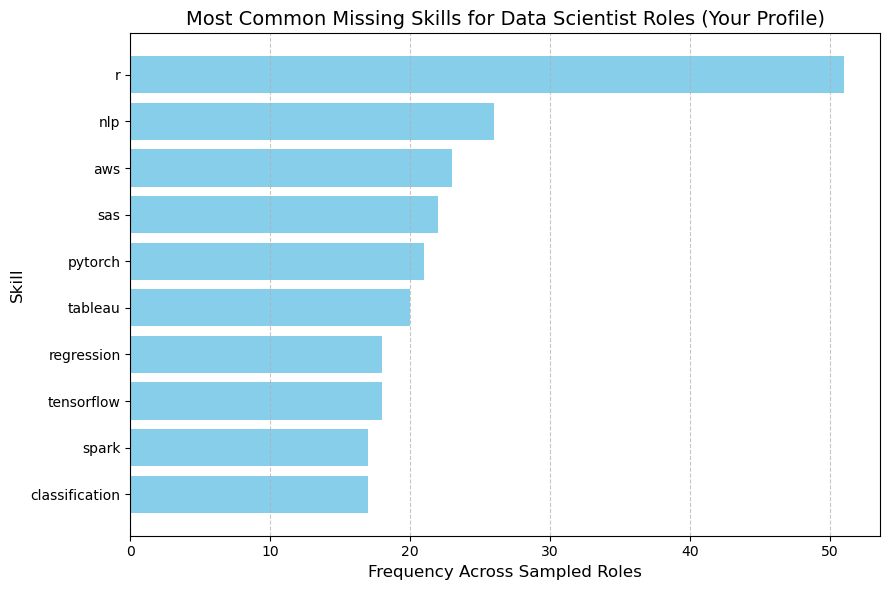

In [13]:
# === 8) Sanity Checks and Missing Skills Plot ===
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported if not already in the first cell

# How many unique skills appear at least once in postings?
# We need to flatten the list of sets into a single set
all_found_skills = set()
for skills_set in postings["_skills_extracted"]:
    all_found_skills.update(skills_set)

print(f"\nUnique skills found in corpus: {len(all_found_skills)} of {len(SKILL_VOCAB)} in vocab (~{round(100*len(all_found_skills)/len(SKILL_VOCAB),1)}%)")

# Top skills frequency across postings (optional corpus insight)
freq = Counter()
for s_set in postings["_skills_extracted"]:
    freq.update(s_set)
print("Top 15 extracted skills overall:", freq.most_common(15))

# Top missing skills for Data Scientist roles given your current profile
user_set = {"python","sql","pandas"}
# Sample up to 100 "Data Scientist" roles for analysis
ds_roles = [r for r in roles_list if "data scientist" in r.lower()][:100]
missing = []
for r in ds_roles:
    # Ensure role_to_skills.get(r, set()) returns a set for set operations
    role_skills = role_to_skills.get(r, set())
    missing.extend(sorted(role_skills - user_set))

miss_counts = Counter(missing).most_common(10)
print("\nTop 10 missing skills for Data Scientist roles (given your profile):", miss_counts)

# Plot
if miss_counts:
    skills, counts = zip(*miss_counts)
    plt.figure(figsize=(9, 6)) # Increased figure size for better readability
    plt.barh(skills[::-1], counts[::-1], color='skyblue') # Reverse for highest at top
    plt.title("Most Common Missing Skills for Data Scientist Roles (Your Profile)", fontsize=14)
    plt.xlabel("Frequency Across Sampled Roles", fontsize=12)
    plt.ylabel("Skill", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    project_root = Path(r"C:\Users\tsabu\Resume Projects\career-skill-recommender")
    img_dir = project_root / "images"
    img_dir.mkdir(parents=True, exist_ok=True)  # ensure images/ exists
    
    plt.savefig(img_dir / "missing_skills_chart.png", dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No missing skills to plot for the sampled Data Scientist roles.")


--- Top 5 Recommended Roles (filtered: data scientist) ---
Remote opportunity for P&C Insurance Data Scientist/Actuary - PR12690A  (similarity=1.0)
Data Scientist - Equity Trading  (similarity=0.751)
Associate Data Scientist - Recent Bio/Chem Grads  (similarity=0.467)
Blockchain Data Scientist  (similarity=0.467)
Clinical data scientist  (similarity=0.467)

--- Top 10 Missing Skills across recommended data scientist roles ---
r (2)
linux (1)
shell (1)


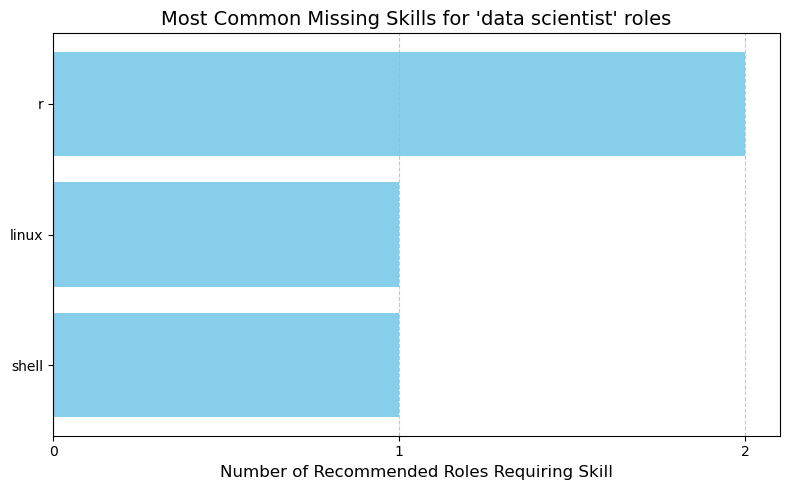

In [81]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def role_report(user_skills, title_filter="data scientist", top_n_roles=5, top_missing=10):
    """
    Generate a report:
      - Top recommended roles filtered by a keyword in the title
      - Top missing skills aggregated from those roles
    """
    # Filtered recommendations
    recommendations = recommend_roles_filtered(user_skills, title_filter=title_filter, top_n=top_n_roles)
    if not recommendations:
        print(f"No roles found for filter '{title_filter}'.")
        return
    
    print(f"\n--- Top {top_n_roles} Recommended Roles (filtered: {title_filter}) ---")
    for role, score in recommendations:
        print(f"{role}  (similarity={score})")
    
    # Collect missing skills from those roles
    user_set = {s.lower().strip() for s in user_skills}
    missing_all = []
    for role, _ in recommendations:
        role_skills = role_to_skills.get(role, set())
        missing_all.extend(sorted(role_skills - user_set))
    
    if not missing_all:
        print("\nNo missing skills identified for these roles.")
        return

    miss_counts = Counter(missing_all).most_common(top_missing)
    print(f"\n--- Top {top_missing} Missing Skills across recommended {title_filter} roles ---")
    for skill, freq in miss_counts:
        print(f"{skill} ({freq})")

    # Plot the top missing skills
    skills, counts = zip(*miss_counts)
    plt.figure(figsize=(8,5))
    plt.barh(skills[::-1], counts[::-1], color="skyblue")
    plt.title(f"Most Common Missing Skills for '{title_filter}' roles", fontsize=14)
    plt.xlabel("Number of Recommended Roles Requiring Skill", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    
    # 🔑 Force integer ticks on x-axis
    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.show()

# === Demo with your current profile ===
user_skills = ["python", "sql", "pandas"]
role_report(user_skills, title_filter="data scientist", top_n_roles=5, top_missing=10)